# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

In [3]:
attributes = df.columns[:-1]
data = df.groupby(attributes[0]).cnt.mean().reset_index()['cnt'][0]
data

2604.1325966850827

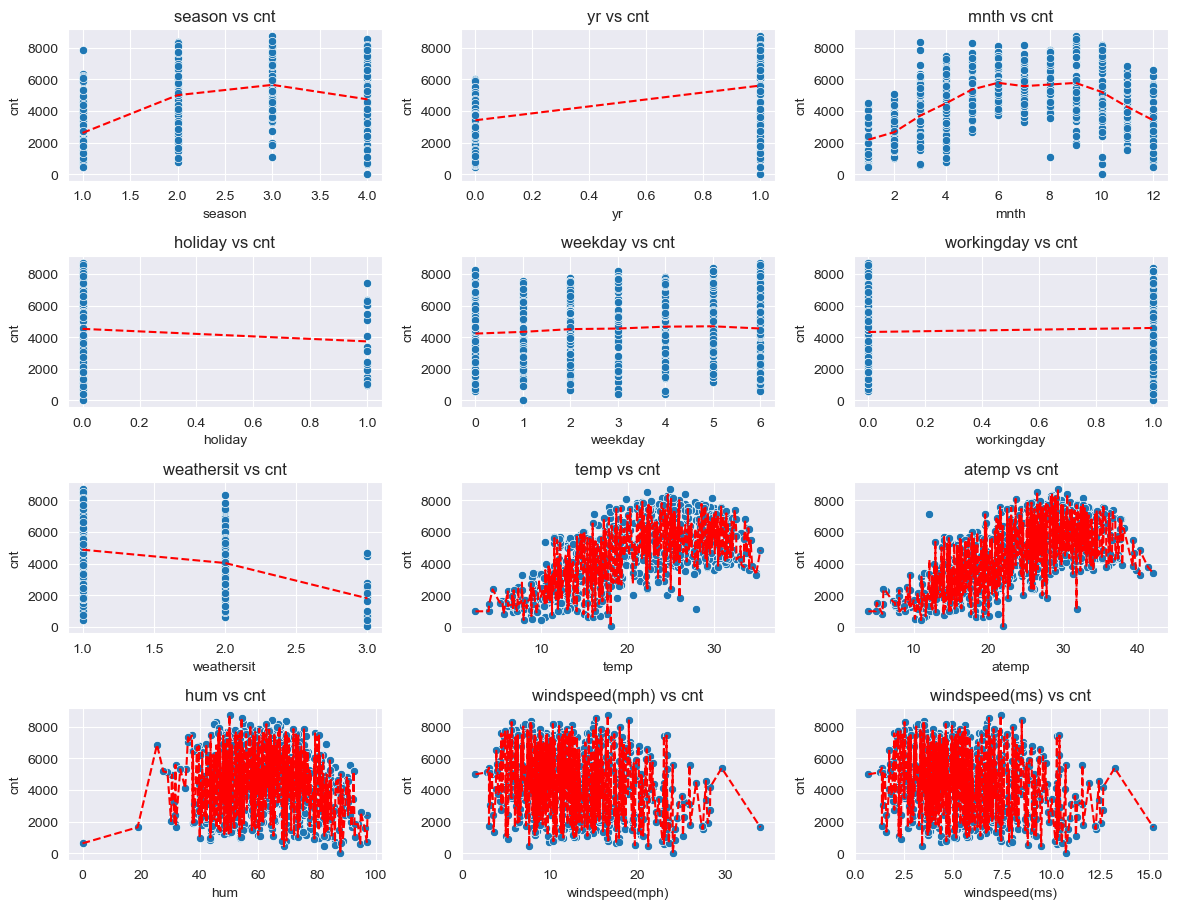

In [4]:
attributes = df.columns.tolist()
attributes.remove('cnt')

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))

for i, attr in enumerate(attributes):
    row, col = i // 3, i % 3
    line = df.groupby(attr)['cnt'].mean().reset_index()
    sns.scatterplot(data=df, x=attr, y='cnt', ax=axes[row, col])
    axes[row, col].plot(line[attr], line['cnt'], color='red', linestyle='--')
    axes[row, col].set_title(f"{attr} vs cnt")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
- Відповідь: лінія середніх значень візуально нагадує параболу
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
- Відповідь: cnt(temp), cnt(atemp)

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [5]:
pearson_corr = df.drop('cnt', axis=1).corrwith(df['cnt'])
pearson_corr.name = "PCC"
pearson_corr.sort_values(ascending=False)

atemp             0.631066
temp              0.627494
yr                0.566710
season            0.406100
mnth              0.279977
weekday           0.067443
workingday        0.061156
holiday          -0.068348
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
weathersit       -0.297391
Name: PCC, dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [6]:
df[["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [7]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [8]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [9]:
linreg = LinearRegression().fit(X, y)
weights = list(zip(df.columns[:-1], linreg.coef_))
linear_weights = pd.DataFrame(weights, columns=['attr', 'weight'])
linear_weights.sort_values(by='weight', ascending=False)

,attr,weight
10,windspeed(mph),1.245387e+13
1,yr,1.021971e+03
8,atemp,5.855673e+02
0,season,5.708656e+02
7,temp,3.674615e+02
4,weekday,1.372263e+02
5,workingday,5.639276e+01
3,holiday,-8.675804e+01
2,mnth,-1.413026e+02
9,hum,-1.456091e+02


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [10]:
lasso = Lasso().fit(X, y)
weights = list(zip(df.columns[:-1], lasso.coef_))
lasso_weights = pd.DataFrame(weights, columns=['attr', 'weight'])
lasso_weights

,attr,weight
0,season,5.602416e+02
1,yr,1.019463e+03
2,mnth,-1.287306e+02
3,holiday,-8.615278e+01
4,weekday,1.373479e+02
5,workingday,5.521237e+01
6,weathersit,-3.323699e+02
7,temp,3.763632e+02
8,atemp,5.765308e+02
9,hum,-1.441292e+02


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [11]:
ridge = Ridge().fit(X, y)
weights = list(zip(df.columns[:-1], ridge.coef_))
ridge_weights = pd.DataFrame(weights, columns=['attr', 'weight'])
ridge_weights

,attr,weight
0,season,563.064572
1,yr,1018.948379
2,mnth,-131.873320
3,holiday,-86.746098
4,weekday,138.005111
5,workingday,55.903110
6,weathersit,-332.349788
7,temp,386.457889
8,atemp,566.347047
9,hum,-145.071327


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [12]:
alphas = np.arange(1, 500, 50)

def fit(model_class, alphas_inner, x_inner, y_inner):
    coefs = []
    for alpha in alphas_inner:
        model = model_class(alpha=alpha).fit(x_inner, y_inner)
        coefs.append(model.coef_)
    return np.array(coefs)

coefs_lasso = fit(Lasso, alphas, X, y)
coefs_ridge = fit(Ridge, alphas, X, y)


Проанализируйте динамику весов при увеличении параметра регуляризации:

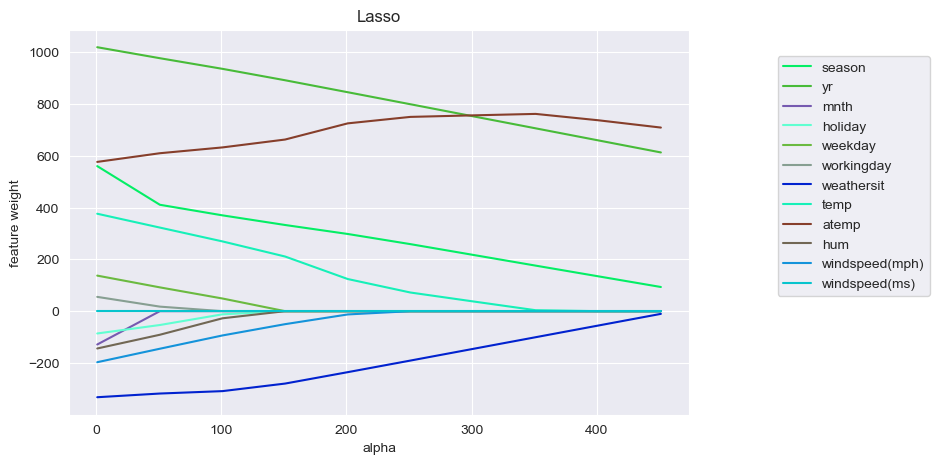

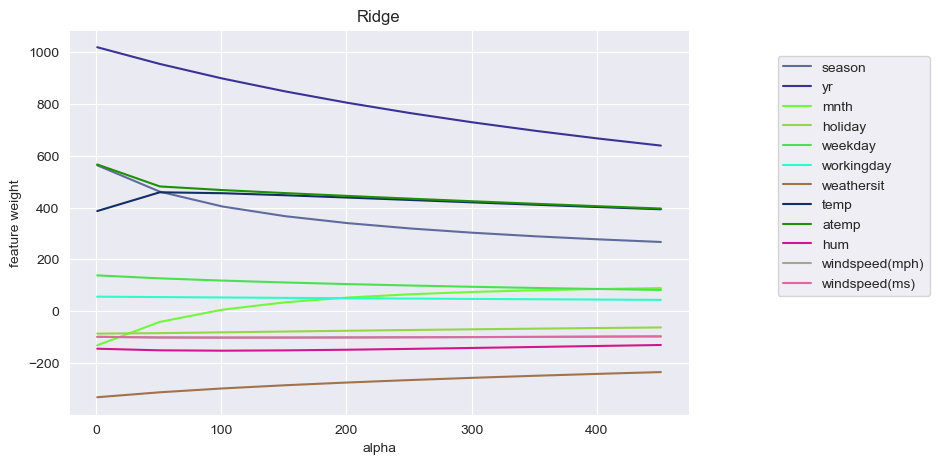

In [13]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
- Відповідь: Lasso
2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
- Відповідь: Lasso використовує L1-регуляризацію, яка додає до функції втрат суму абсолютних значень коефіцієнтів, помножену на α. По суті, регуляризація карає модель за великі ваги.
3. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
- Відповідь: `windspeed(ms)` є практично нулем при $\alpha \gtrsim 0$ для $L_1$. Однак це не є правилом, і в деяких випадках windspeed може залишатися в моделі навіть за високих значень alpha. Що стосується Ridge, він, найімовірніше, не виключить ознаку повністю, але може істотно зменшити її коефіцієнт за великого alpha.
4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
- Відповідь: L1, оскільки основна властивість LASSO полягає в тому, що воно може обнулити коефіцієнти деяких ознак, що фактично виключає їх із моделі. Це робить LASSO корисним для добору ознак, особливо якщо передбачається, що багато ознак не важливі.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

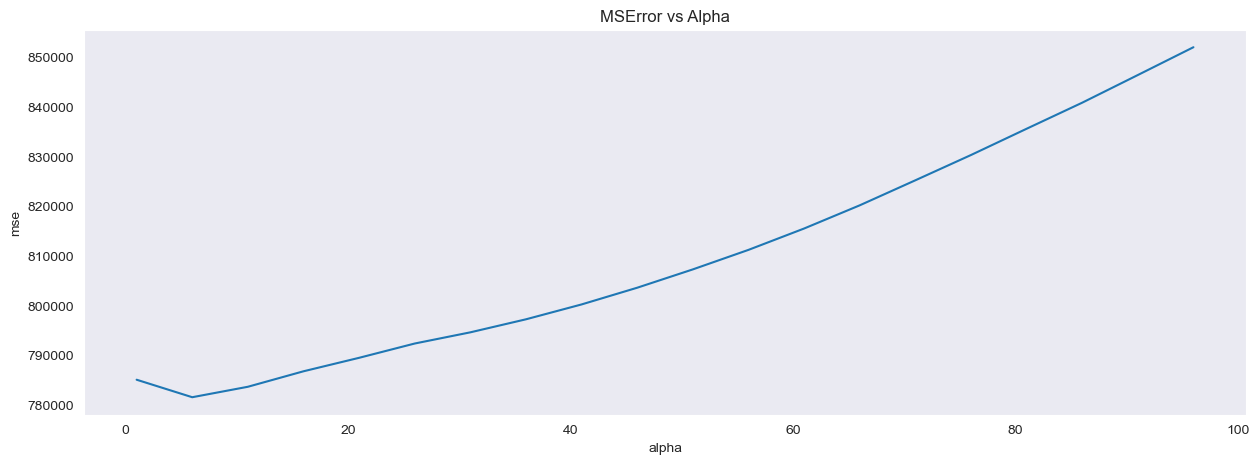

In [14]:
alphas = np.arange(1, 100, 5)

lasso_cv = LassoCV(alphas=alphas, cv=3).fit(X, y)
x1 = lasso_cv.alphas_
y1 = lasso_cv.mse_path_.mean(axis=1)

plt.figure(figsize=(15, 5))
plt.plot(x1, y1)
plt.title("MSError vs Alpha")
plt.xlabel('alpha')
plt.ylabel("mse")
plt.grid()
plt.show()

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


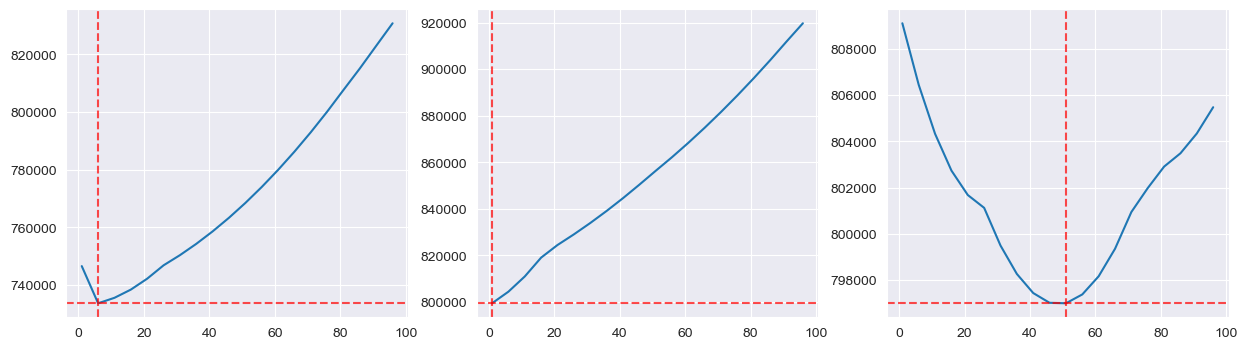

{'k1': {'alpha': 6, 'mse': 733725.7604052247}, 'k2': {'alpha': 1, 'mse': 799433.1673691716}, 'k3': {'alpha': 51, 'mse': 796979.8955193633}}


In [15]:
# print(lasso_cv.alpha_)
# print(lasso_cv.coef_)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
df2 = pd.DataFrame(lasso_cv.mse_path_, index= lasso_cv.alphas_)
df2.columns = ['k1', 'k2', 'k3']
min_points = dict()
for i in range(3):
    axes[i].plot(lasso_cv.alphas_, df2[f'k{i+1}'])
    min_alpha = df2.iloc[:, i].idxmin()
    mse_min_alpha = df2.loc[min_alpha, f"k{i+1}"]
    axes[i].axvline(min_alpha, color='red', linestyle='--', alpha=0.7)
    axes[i].axhline(mse_min_alpha, color='red', linestyle='--', alpha=0.7)
    min_points[f"k{i+1}"] = {'alpha': min_alpha, 'mse': mse_min_alpha}
plt.show()
print(min_points)

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

In [16]:
target_columns = df.columns.tolist()
target_columns.remove('cnt')
attrib_weights = pd.Series(lasso_cv.coef_, target_columns).sort_values(ascending=False)
attrib_weights

yr                1.015060e+03
atemp             5.813969e+02
season            5.320190e+02
temp              3.706799e+02
weekday           1.325045e+02
workingday        5.155709e+01
windspeed(ms)    -2.685631e-08
holiday          -8.329396e+01
mnth             -1.000395e+02
hum              -1.400074e+02
windspeed(mph)   -1.917714e+02
weathersit       -3.305599e+02
dtype: float64

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

In [17]:
attrib_weights.head(4)

yr        1015.060223
atemp      581.396931
season     532.018983
temp       370.679855
dtype: float64

__Ответ:__
- Так, помітна зростаюча лінійна залежність для атрибутів temp, atemp і season. Щодо year, лінійну залежність підтвежжувати неможливо, оскільки всього 2 точки
Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?
- Вважаю що ні, у випадку температур можна помітити нелінійність ближче до високих температур.

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

In [18]:
attrib_weights.tail(3)

hum              -140.007406
windspeed(mph)   -191.771408
weathersit       -330.559857
dtype: float64

__Ответ:__ Так, ці 3 ознаки пов'язані саме з погоніми умовами, тому чим гірше погода тим меньша кількисть випадків оренди.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

In [19]:
filtered_weights = attrib_weights[(attrib_weights > -1e-3) & (attrib_weights < 1e-3)]
filtered_weights

windspeed(ms)   -2.685631e-08
dtype: float64

__Ответ:__ windspeed(ms) повторює windspeed(mph) тому модель виключила цю лінійно залежну величину. З цього ж приводу не можна стверджувати що windspeed(ms) не впливає на кількість оренд. Ознака windspeed(ms) так само впливає на кількість оренд як і windspeed(mph)

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.